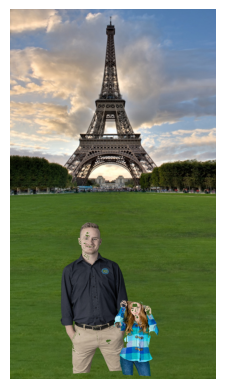

In [48]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Please DO NOT add any additional imports to this notebook
# Functionality using libraries other than those listed above will not be graded

def process_image(BG: np.ndarray, I1: np.ndarray, I2: np.ndarray) -> np.ndarray:
    # Convert to HSV
    hsv1 = cv2.cvtColor(I1, cv2.COLOR_BGR2HSV)
    hsv2 = cv2.cvtColor(I2, cv2.COLOR_BGR2HSV)
    
    # Define color ranges - tweaked for better green screen removal
    lower_green = np.array([35, 30, 30])
    upper_green = np.array([85, 255, 255])
    lower_white = np.array([0, 0, 180])
    upper_white = np.array([180, 40, 255])
    
    # Create initial masks
    mask_green1 = cv2.inRange(hsv1, lower_green, upper_green)
    mask_green2 = cv2.inRange(hsv2, lower_green, upper_green)
    mask_white1 = cv2.inRange(hsv1, lower_white, upper_white)
    mask_white2 = cv2.inRange(hsv2, lower_white, upper_white)
    
    # Combine masks
    mask1 = cv2.bitwise_not(cv2.bitwise_or(mask_green1, mask_white1))
    mask2 = cv2.bitwise_not(cv2.bitwise_or(mask_green2, mask_white2))
    
    # Morphological operations for mask cleanup
    kernel_small = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    kernel_medium = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    
    # Process both masks
    for mask in [mask1, mask2]:
        # Close small holes
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel_medium)
        # Remove noise
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel_small)
        # Edge enhancement
        edges = cv2.Canny(mask, 100, 200)
        edges = cv2.dilate(edges, kernel_small, iterations=1)
        mask = cv2.add(mask, edges)
    
    # Apply Gaussian blur for smoother edges
    mask1 = cv2.GaussianBlur(mask1, (3, 3), 0)
    mask2 = cv2.GaussianBlur(mask2, (3, 3), 0)
    
    # Convert masks to 3D
    mask1_3d = cv2.cvtColor(mask1, cv2.COLOR_GRAY2BGR) / 255.0
    mask2_3d = cv2.cvtColor(mask2, cv2.COLOR_GRAY2BGR) / 255.0
    
    # Get background dimensions
    bg_height, bg_width = BG.shape[:2]
    
    # Relative sizing parameters
    MAX_HEIGHT_RATIO = 1.2  # Maximum height as proportion of background
    PERSON2_SCALE = 0.93     # Second person's height relative to first
    WIDTH_ADJUSTMENT = 1.1   # Width adjustment factor
    
    # Calculate base height (for first person)
    target_height = int(bg_height * MAX_HEIGHT_RATIO)
    
    # Calculate aspects and dimensions
    aspect1 = I1.shape[1] / I1.shape[0]
    aspect2 = I2.shape[1] / I2.shape[0]
    
    # First person dimensions
    h1 = target_height
    w1 = int(h1 * aspect1 * WIDTH_ADJUSTMENT)
    
    # Second person dimensions (relative to first)
    h2 = int(h1 * PERSON2_SCALE)
    w2 = int(h2 * aspect2 * WIDTH_ADJUSTMENT)
    
    # Check and adjust for maximum width
    max_individual_width = int(bg_width * 0.8)  # Max 40% of background width
    if w1 > max_individual_width:
        w1 = max_individual_width
        h1 = int(w1 / (aspect1 * WIDTH_ADJUSTMENT))
        # Recalculate second person dimensions
        h2 = int(h1 * PERSON2_SCALE)
        w2 = int(h2 * aspect2 * WIDTH_ADJUSTMENT)
    if w2 > max_individual_width:
        w2 = max_individual_width
        h2 = int(w2 / (aspect2 * WIDTH_ADJUSTMENT))
    
    # Resize images and masks with high-quality interpolation
    I1_resized = cv2.resize(I1, (w1, h1), interpolation=cv2.INTER_LANCZOS4)
    I2_resized = cv2.resize(I2, (w2, h2), interpolation=cv2.INTER_LANCZOS4)
    mask1_resized = cv2.resize(mask1_3d, (w1, h1), interpolation=cv2.INTER_LINEAR)
    mask2_resized = cv2.resize(mask2_3d, (w2, h2), interpolation=cv2.INTER_LINEAR)
    
    # Position calculation
    BOTTOM_MARGIN = 0.00002  # Bottom margin as proportion of background height
    GAP_RATIO = 2    # Gap between people as proportion of background width
    
    y_margin = int(bg_height * BOTTOM_MARGIN)
    gap = int(bg_width * GAP_RATIO)
    
    # Center the group
    total_width = w1 + gap + w2
    x_start = (bg_width - total_width) // 2
    
    # Calculate positions with slight offset for depth
    x1 = x_start
    x2 = x1 + w1 + gap
    y1 = bg_height - h1 - y_margin
    y2 = bg_height - h2 - y_margin  # Slightly higher for depth perception
    
    # Ensure positions are within bounds
    x1 = max(0, min(x1, bg_width - w1))
    x2 = max(0, min(x2, bg_width - w2))
    y1 = max(0, min(y1, bg_height - h1))
    y2 = max(0, min(y2, bg_height - h2))
    
    # Create result image
    result = BG.copy()
    
    # Define ROIs
    roi1 = result[y1:y1+h1, x1:x1+w1]
    roi2 = result[y2:y2+h2, x2:x2+w2]
    
    # Ensure ROIs match resized image dimensions
    h1, w1 = roi1.shape[:2]
    h2, w2 = roi2.shape[:2]
    
    # Final resize to match ROI dimensions
    I1_resized = cv2.resize(I1_resized, (w1, h1), interpolation=cv2.INTER_LANCZOS4)
    I2_resized = cv2.resize(I2_resized, (w2, h2), interpolation=cv2.INTER_LANCZOS4)
    mask1_resized = cv2.resize(mask1_resized, (w1, h1), interpolation=cv2.INTER_LINEAR)
    mask2_resized = cv2.resize(mask2_resized, (w2, h2), interpolation=cv2.INTER_LINEAR)
    
    # Blend images
    roi1[:] = roi1 * (1 - mask1_resized) + I1_resized * mask1_resized
    roi2[:] = roi2 * (1 - mask2_resized) + I2_resized * mask2_resized
    
    # Convert to RGB for display
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    
    return result

# Please DO NOT change any of the code below. All modifications to this template should
# occur inside the **process_image** function


BG = cv2.imread('./background.jpg')
I1 = cv2.imread('./male.jpg')
I2 = cv2.imread('./female.jpg')

merged = process_image(BG, I1, I2)

plt.imshow(merged)
plt.axis('off')
plt.show()
